# MODELING

In [95]:
import polars as pl
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from IPython.display import display

In [28]:
# read in data
defense_df = pl.read_parquet("../data/defense_season_stats.parquet")
games_df = pl.read_parquet("../data/games_full_data.parquet")
qb_df = pl.read_parquet("../data/qb_game_stats.parquet")

In [29]:
# join all data together 

model_df = (
    qb_df
    .join(
        games_df.select([
            "game_id",
            "season",
            "is_soldier_field",
            "temp",
            "wind",
            "precip",
            "temp_bin",
        ]),
        on="game_id",
        how="inner",
    )
    .join(
        defense_df.select([
            "season",
            "defense_team",
            "def_epa_allowed_season",
        ]),
        on=["season", "defense_team"],
        how="left",
    )
    .with_columns([
        (pl.col("temp") - pl.col("temp").mean()).alias("temp_c"),
        (pl.col("wind") - pl.col("wind").mean()).alias("wind_c"),
        (pl.col("def_epa_allowed_season") - pl.col("def_epa_allowed_season").mean()).alias("opp_def_epa_c"),
    ])
    .select([
        "game_id",
        "epa_per_dropback",
        pl.col("is_home").cast(pl.Int8).alias("is_home"),
        pl.col("is_soldier_field").cast(pl.Int8).alias("soldier_field"),
        "temp_c",
        "wind_c",
        pl.col("precip").cast(pl.Int8).alias("precip"),
        "opp_def_epa_c",
        "temp_bin",
    ])
)

In [30]:
# Convert to pandas for statsmodels
pdf = model_df.to_pandas()
pdf["temp_bin"] = pd.Categorical(
    pdf["temp_bin"],
    categories=["below_0", "0_to_32", "32_to_50", "above_50"],
    ordered=True
)

In [31]:
# Model 1: Baseline
m1 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c",
    data=pdf
).fit(cov_type="HC3")

In [32]:
# Model 2: Baseline and Soldier Field
m2 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field",
    data=pdf
).fit(cov_type="HC3")

In [33]:
# Model 3.1: Baseline, Soldier Field, and weather (treating temperature as a linear variable)
m3_v1 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field + temp_c + wind_c + precip",
    data=pdf
).fit(cov_type="HC3")

In [34]:
# Model 3.2: Baseline, Soldier Field, and weather (treating temperature as a categorical variable)
m3_v2 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field + C(temp_bin) + wind_c + precip",
    data=pdf
).fit(cov_type="HC3")

In [35]:
# Model 4.1: Baseline, Soldier Field, weather, and Soldier Field / weather interactgion (treating temperature as a linear variable)
m4_v1 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field + temp_c + wind_c + precip + soldier_field:temp_c + soldier_field:wind_c + soldier_field:precip",
    data=pdf
).fit(cov_type="HC3")

In [36]:
# Model 4.2: Baseline, Soldier Field, weather, and Soldier Field / weather interaction (treating temperature as a categorical variable)
m4_v2 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field + C(temp_bin) + wind_c + precip + soldier_field:C(temp_bin) + soldier_field:wind_c + soldier_field:precip",
    data=pdf
).fit(cov_type="HC3")

# RESULTS

### Model Summaries

In [68]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     68.12
Date:                Wed, 07 Jan 2026   Prob (F-statistic):           3.94e-30
Time:                        10:48:23   Log-Likelihood:                -13013.
No. Observations:               11290   AIC:                         2.603e+04
Df Residuals:                   11287   BIC:                         2.605e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0210      0.010     -2.115      0.034      -0.041      -0.002
is_home           0.0074      0.014      0.513      0.608      -0.021       0.036
opp_def_epa_c     1.6534      0.142     11.648      0.000       1.375       1.932
==============================================================================
Omnibus:                     3514.858   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           234939.009
Skew:                           0.630   Prob(JB):                         0.00
Kurtosis:                      25.312   Cond. No.                         21.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [69]:
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     46.72
Date:                Wed, 07 Jan 2026   Prob (F-statistic):           5.34e-30
Time:                        10:48:42   Log-Likelihood:                -13011.
No. Observations:               11290   AIC:                         2.603e+04
Df Residuals:                   11286   BIC:                         2.606e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0179      0.010     -1.776      0.076      -0.038       0.002
is_home           0.0075      0.014      0.523      0.601      -0.021       0.036
opp_def_epa_c     1.6353      0.142     11.497      0.000       1.357       1.914
soldier_field    -0.0796      0.039     -2.037      0.042      -0.156      -0.003
==============================================================================
Omnibus:                     3518.312   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           234915.850
Skew:                           0.632   Prob(JB):                         0.00
Kurtosis:                      25.311   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [70]:
m3_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     29.52
Date:                Wed, 07 Jan 2026   Prob (F-statistic):           2.71e-35
Time:                        10:48:54   Log-Likelihood:                -12996.
No. Observations:               11290   AIC:                         2.601e+04
Df Residuals:                   11283   BIC:                         2.606e+04
Df Model:                           6                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0109      0.010     -1.057      0.290      -0.031       0.009
is_home           0.0080      0.014      0.558      0.577      -0.020       0.036
opp_def_epa_c     1.6099      0.142     11.316      0.000       1.331       1.889
soldier_field    -0.0639      0.039     -1.625      0.104      -0.141       0.013
temp_c            0.0007      0.000      1.558      0.119      -0.000       0.001
wind_c           -0.0052      0.001     -3.972      0.000      -0.008      -0.003
precip           -0.0706      0.022     -3.183      0.001      -0.114      -0.027
==============================================================================
Omnibus:                     3512.199   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           236236.448
Skew:                           0.627   Prob(JB):                         0.00
Kurtosis:                      25.374   Cond. No.                         323.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [71]:
m3_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     22.25
Date:                Wed, 07 Jan 2026   Prob (F-statistic):           5.09e-34
Time:                        10:49:06   Log-Likelihood:                -12995.
No. Observations:               11290   AIC:                         2.601e+04
Df Residuals:                   11281   BIC:                         2.607e+04
Df Model:                           8                                         
Covariance Type:                  HC3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0083      0.088     -0.094      0.925      -0.182       0.165
C(temp_bin)[T.0_to_32]     -0.0427      0.093     -0.461      0.645      -0.224       0.139
C(temp_bin)[T.32_to_50]    -0.0158      0.089     -0.176      0.860      -0.191       0.159
C(temp_bin)[T.above_50]     0.0058      0.089      0.065      0.948      -0.168       0.180
is_home                     0.0081      0.014      0.564      0.573      -0.020       0.036
opp_def_epa_c               1.6070      0.142     11.302      0.000       1.328       1.886
soldier_field              -0.0633      0.039     -1.614      0.107      -0.140       0.014
wind_c                     -0.0051      0.001     -3.942      0.000      -0.008      -0.003
precip                     -0.0703      0.022     -3.179      0.001      -0.114      -0.027
==============================================================================
Omnibus:                     3511.930   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           236145.249
Skew:                           0.627   Prob(JB):                         0.00
Kurtosis:                      25.370   Cond. No.                         466.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [67]:
m4_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     20.32
Date:                Wed, 07 Jan 2026   Prob (F-statistic):           2.49e-34
Time:                        10:39:42   Log-Likelihood:                -12994.
No. Observations:               11290   AIC:                         2.601e+04
Df Residuals:                   11280   BIC:                         2.608e+04
Df Model:                           9                                         
Covariance Type:                  HC3                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0104      0.010     -1.002      0.316      -0.031       0.010
is_home                  0.0081      0.014      0.561      0.575      -0.020       0.036
opp_def_epa_c            1.6129      0.142     11.346      0.000       1.334       1.892
soldier_field           -0.0556      0.048     -1.148      0.251      -0.150       0.039
temp_c                   0.0005      0.000      1.226      0.220      -0.000       0.001
wind_c                  -0.0054      0.001     -4.080      0.000      -0.008      -0.003
precip                  -0.0754      0.023     -3.251      0.001      -0.121      -0.030
soldier_field:temp_c     0.0034      0.003      1.299      0.194      -0.002       0.009
soldier_field:wind_c     0.0075      0.009      0.830      0.407      -0.010       0.025
soldier_field:precip     0.0827      0.074      1.122      0.262      -0.062       0.227
==============================================================================
Omnibus:                     3516.667   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           235632.262
Skew:                           0.630   Prob(JB):                         0.00
Kurtosis:                      25.345   Cond. No.                         324.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [72]:
m4_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     15.13
Date:                Wed, 07 Jan 2026   Prob (F-statistic):           3.92e-32
Time:                        10:49:33   Log-Likelihood:                -12993.
No. Observations:               11290   AIC:                         2.601e+04
Df Residuals:                   11277   BIC:                         2.611e+04
Df Model:                          12                                         
Covariance Type:                  HC3                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.0072      0.089     -0.081      0.935      -0.181       0.166
C(temp_bin)[T.0_to_32]                   -0.0281      0.093     -0.303      0.762      -0.210       0.154
C(temp_bin)[T.32_to_50]                  -0.0196      0.089     -0.219      0.827      -0.195       0.156
C(temp_bin)[T.above_50]                   0.0048      0.089      0.054      0.957      -0.169       0.179
is_home                                   0.0084      0.014      0.582      0.561      -0.020       0.037
opp_def_epa_c                             1.6071      0.142     11.302      0.000       1.328       1.886
soldier_field                            -0.0900      0.048     -1.862      0.063      -0.185       0.005
soldier_field:C(temp_bin)[T.0_to_32]     -0.1655      0.110     -1.499      0.134      -0.382       0.051
soldier_field:C(temp_bin)[T.32_to_50]     0.0610      0.054      1.127      0.260      -0.045       0.167
soldier_field:C(temp_bin)[T.above_50]     0.0144      0.058      0.248      0.804      -0.100       0.128
wind_c                                   -0.0053      0.001     -4.070      0.000      -0.008      -0.003
precip                                   -0.0754      0.023     -3.266      0.001      -0.121      -0.030
soldier_field:wind_c                      0.0077      0.009      0.842      0.400      -0.010       0.025
soldier_field:precip                      0.0906      0.076      1.196      0.232      -0.058       0.239
==============================================================================
Omnibus:                     3523.355   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           235792.880
Skew:                           0.634   Prob(JB):                         0.00
Kurtosis:                      25.352   Cond. No.                     9.20e+16
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is 3.84e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [73]:
# function to return a baseline - a typical game from the dataset
def baseline_row(df: pd.DataFrame) -> pd.DataFrame:
    base = df.mean(numeric_only=True).to_frame().T
    base["temp_bin"] = df["temp_bin"].mode().iloc[0]
    return base


In [83]:
# necessary vars
temp_order = ["below_0", "0_to_32", "32_to_50", "above_50"]
wind_range = np.linspace(-15, 25, 60)
temp_range = np.linspace(pdf["temp_c"].quantile(0.05), pdf["temp_c"].quantile(0.95), 60)


In [74]:
# predict epa per dropback, using baseline data and any overrides necessary for a given test
def predict_from_model(model, df: pd.DataFrame, **kwargs) -> float:
    base = baseline_row(df)
    for k, v in kwargs.items():
        base[k] = v
    base["temp_bin"] = pd.Categorical(base["temp_bin"], categories=temp_order, ordered=True)
    return float(model.predict(base).iloc[0])

In [81]:
# calculate wind impact on predicted epa for soldier field and non soldier field play
pred_wind_sf = [
    predict_from_model(m4_v1, pdf, soldier_field=1, wind_c=w, is_home=0, precip=0, opp_def_epa_c=0)
    for w in wind_range
]
pred_wind_else = [
    predict_from_model(m4_v1, pdf, soldier_field=0, wind_c=w, is_home=0, precip=0, opp_def_epa_c=0)
    for w in wind_range
]

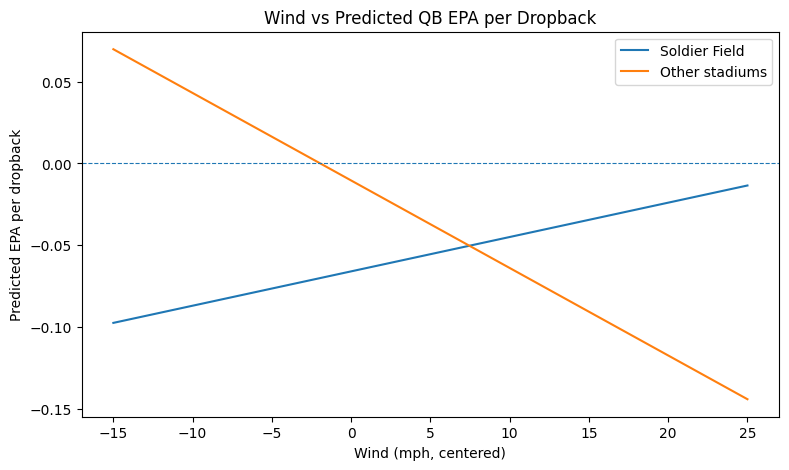

In [82]:
plt.figure(figsize=(9,5))
plt.plot(wind_range, pred_wind_sf, label="Soldier Field")
plt.plot(wind_range, pred_wind_else, label="Other stadiums")
plt.axhline(0, linestyle="--", linewidth=0.8)
plt.xlabel("Wind (mph, centered)")
plt.ylabel("Predicted EPA per dropback")
plt.title("Wind vs Predicted QB EPA per Dropback")
plt.legend()
plt.show()

In [84]:
# calculate temperature (linear) impact on predicted epa for soldier field and non soldier field play
pred_temp_sf = [
    predict_from_model(m4_v1, pdf, soldier_field=1, temp_c=t, is_home=0, precip=0, opp_def_epa_c=0, wind_c=0)
    for t in temp_range
]
pred_temp_else = [
    predict_from_model(m4_v1, pdf, soldier_field=0, temp_c=t, is_home=0, precip=0, opp_def_epa_c=0, wind_c=0)
    for t in temp_range
]

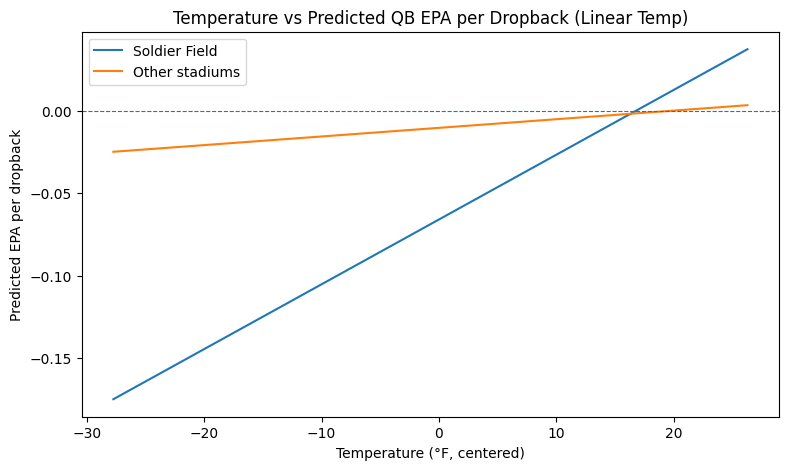

In [85]:
plt.figure(figsize=(9,5))
plt.plot(temp_range, pred_temp_sf, label="Soldier Field")
plt.plot(temp_range, pred_temp_else, label="Other stadiums")
plt.axhline(0, linestyle="--", linewidth=0.8)
plt.xlabel("Temperature (°F, centered)")
plt.ylabel("Predicted EPA per dropback")
plt.title("Temperature vs Predicted QB EPA per Dropback (Linear Temp)")
plt.legend()
plt.show()

In [86]:
# calculate precipitation impact on predicted epa for soldier field and non soldier field play
vals = []
for sf in [0, 1]:
    no_p = predict_from_model(m4_v1, pdf, soldier_field=sf, precip=0, is_home=0, opp_def_epa_c=0, wind_c=0, temp_c=0)
    yes_p = predict_from_model(m4_v1, pdf, soldier_field=sf, precip=1, is_home=0, opp_def_epa_c=0, wind_c=0, temp_c=0)
    vals.append((sf, no_p, yes_p))

labels = ["Other stadiums", "Soldier Field"]
no_precip = [vals[0][1], vals[1][1]]
yes_precip = [vals[0][2], vals[1][2]]

x = np.arange(len(labels))

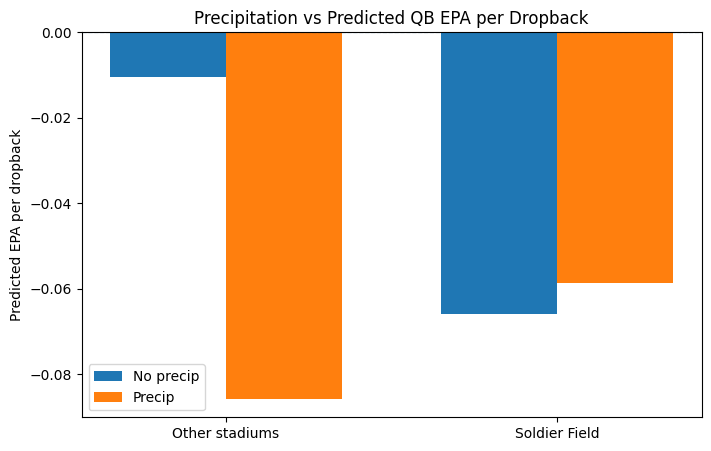

In [87]:
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, no_precip, width, label="No precip")
plt.bar(x + width/2, yes_precip, width, label="Precip")
plt.axhline(0, linestyle="--", linewidth=0.8)
plt.xticks(x, labels)
plt.ylabel("Predicted EPA per dropback")
plt.title("Precipitation vs Predicted QB EPA per Dropback")
plt.legend()
plt.show()

In [88]:
# Standardized comparison points for impact table
wind_lo, wind_hi = -10, 10
temp_lo, temp_hi = pdf["temp_c"].quantile(0.05), pdf["temp_c"].quantile(0.95)

In [90]:
# all experiments used for impact table
# some variables changed, but some held fixed per experiment
experiments = [
    {
        "label": "Wind (−10 to +10)",
        "var": "wind_c",
        "lo": wind_lo,
        "hi": wind_hi,
        "fixed": {"temp_c": 0, "precip": 0},
    },
    {
        "label": "Temp (p5 to p95)",
        "var": "temp_c",
        "lo": temp_lo,
        "hi": temp_hi,
        "fixed": {"wind_c": 0, "precip": 0},
    },
    {
        "label": "Precip (0 to 1)",
        "var": "precip",
        "lo": 0,
        "hi": 1,
        "fixed": {"wind_c": 0, "temp_c": 0},
    },
]

# these are fixed for each experiment
base_controls = {"is_home": 0, "opp_def_epa_c": 0}

In [91]:
# create impact table data
rows = []

for exp in experiments:
    label = exp["label"]
    var = exp["var"]
    lo = exp["lo"]
    hi = exp["hi"]
    fixed = exp["fixed"]

    # Effect elsewhere (soldier_field = 0)
    pred_else_hi = predict_from_model(m4_v1, pdf, soldier_field=0, **base_controls, **fixed, **{var: hi})
    pred_else_lo = predict_from_model(m4_v1, pdf, soldier_field=0, **base_controls, **fixed, **{var: lo})
    else_effect = pred_else_hi - pred_else_lo

    # Effect at Soldier Field (soldier_field = 1)
    pred_sf_hi = predict_from_model(m4_v1, pdf, soldier_field=1, **base_controls, **fixed, **{var: hi})
    pred_sf_lo = predict_from_model(m4_v1, pdf, soldier_field=1, **base_controls, **fixed, **{var: lo})
    sf_effect = pred_sf_hi - pred_sf_lo

    rows.append([label, else_effect, sf_effect, sf_effect - else_effect])


In [96]:
# create and display impact table
impact_table = pd.DataFrame(
    rows,
    columns=[
        "Weather change",
        "Effect elsewhere (Change in EPA/DB)",
        "Effect at Soldier Field (Change in EPA/DB)",
        "Amplification (SF − elsewhere)",
    ],
)

display(impact_table)

,Weather change,Effect elsewhere (Change in EPA/DB),Effect at Soldier Field (Change in EPA/DB),Amplification (SF − elsewhere)
0,Wind (−10 to +10),-0.107022,0.042010,0.149031
1,Temp (p5 to p95),0.028254,0.212262,0.184008
2,Precip (0 to 1),-0.075390,0.007283,0.082673


In [101]:
# Temperature grid (centered)
temp_vals = np.linspace(
    pdf["temp_c"].quantile(0.05),
    pdf["temp_c"].quantile(0.95),
    60
)

In [102]:
# create predictions using linear temperature
pred_linear_else = [
    predict_from_model(
        m4_v1, pdf,
        soldier_field=0,
        temp_c=t,
        is_home=0, wind_c=0, precip=0, opp_def_epa_c=0
    )
    for t in temp_vals
]

pred_linear_sf = [
    predict_from_model(
        m4_v1, pdf,
        soldier_field=1,
        temp_c=t,
        is_home=0, wind_c=0, precip=0, opp_def_epa_c=0
    )
    for t in temp_vals
]

In [103]:
#create predictions using categorical temperature
pred_cat_else = [
    predict_from_model(
        m4_v2, pdf,
        soldier_field=0,
        temp_bin=b,
        is_home=0, wind_c=0, precip=0, opp_def_epa_c=0
    )
    for b in temp_order
]

pred_cat_sf = [
    predict_from_model(
        m4_v2, pdf,
        soldier_field=1,
        temp_bin=b,
        is_home=0, wind_c=0, precip=0, opp_def_epa_c=0
    )
    for b in temp_order
]

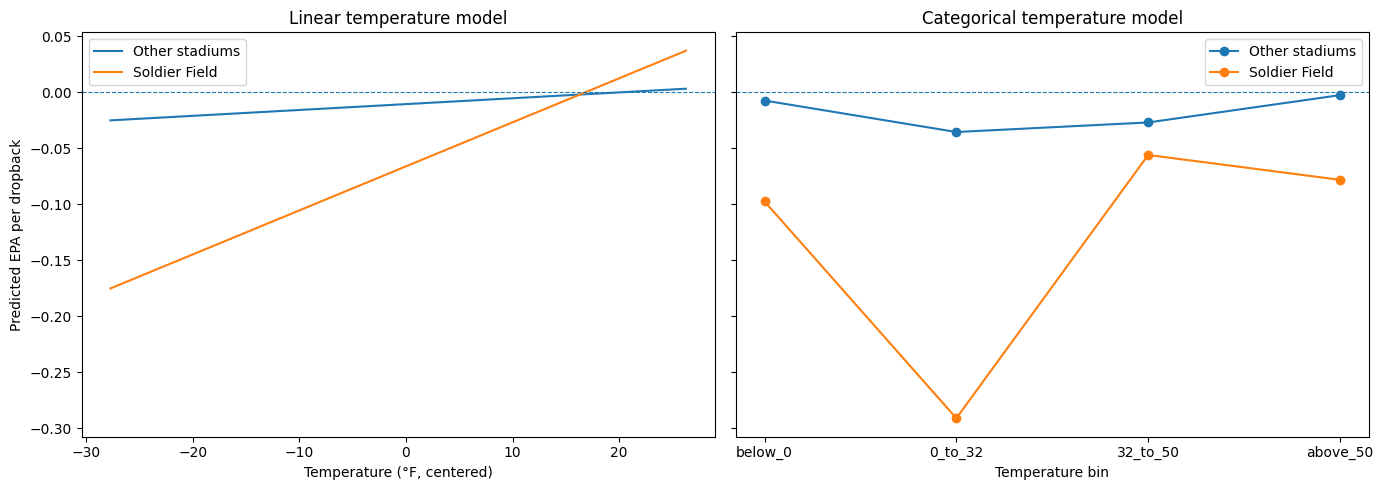

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Linear temp
axes[0].plot(temp_vals, pred_linear_else, label="Other stadiums")
axes[0].plot(temp_vals, pred_linear_sf, label="Soldier Field")
axes[0].axhline(0, linestyle="--", linewidth=0.8)
axes[0].set_title("Linear temperature model")
axes[0].set_xlabel("Temperature (°F, centered)")
axes[0].set_ylabel("Predicted EPA per dropback")
axes[0].legend()

# Categorical temp
axes[1].plot(temp_order, pred_cat_else, marker="o", label="Other stadiums")
axes[1].plot(temp_order, pred_cat_sf, marker="o", label="Soldier Field")
axes[1].axhline(0, linestyle="--", linewidth=0.8)
axes[1].set_title("Categorical temperature model")
axes[1].set_xlabel("Temperature bin")
axes[1].legend()

plt.tight_layout()
plt.show()